In [2]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.models import squeezenet1_1
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms
import seaborn as sns

In [10]:
def load_data(train_dir, valid_dir, batch_size, img_size):
    """Load and transform the training and validation datasets."""
    # Define transformations for the training data
    train_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.ToTensor(),  # Convert images to tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
    ])

    # Define transformations for the validation data
    valid_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),  # Convert images to tensors
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
    ])

    # Load the datasets with ImageFolder
    train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
    valid_data = datasets.ImageFolder(valid_dir, transform=valid_transforms)

    # Define the data loaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

    return train_loader, valid_loader, len(train_data.classes)

class CNN(nn.Module):
    """Convolutional Neural Network model for image classification using SqueezeNet."""
    
    def __init__(self, base_model, num_classes, unfreezed_layers=0):
        """CNN model initializer."""
        super().__init__()
        self.base_model = base_model
        self.num_classes = num_classes

        # Freeze all parameters initially
        for param in self.base_model.parameters():
            param.requires_grad = False

        # Unfreeze the last few layers as specified
        if unfreezed_layers > 0:
            for child in list(self.base_model.children())[-unfreezed_layers:]:
                for param in child.parameters():
                    param.requires_grad = True

        # Replace the classifier of the SqueezeNet model
        # SqueezeNet uses 'classifier' as its final part rather than 'fc'
        self.base_model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        self.base_model.num_classes = num_classes
        
    def forward(self, x):
        """Forward pass of the model."""
        x = self.base_model(x)
        return x
    def predict(self, image):
        return(self(image))

    def train_model(self, train_loader, valid_loader, optimizer, criterion, epochs, nepochs_to_save=10, start_epoch=0):
        """Train the model, save checkpoints, and output training and validation metrics."""
        for epoch in range(epochs):
            self.train()
            train_loss = train_accuracy = 0.0
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_accuracy += (outputs.argmax(1) == labels).sum().item()

            train_loss /= len(train_loader)
            train_accuracy /= len(train_loader.dataset)

            self.eval()
            valid_loss = valid_accuracy = 0.0
            with torch.no_grad():
                for images, labels in valid_loader:
                    outputs = self(images)
                    loss = criterion(outputs, labels)
                    valid_loss += loss.item()
                    valid_accuracy += (outputs.argmax(1) == labels).sum().item()

            valid_loss /= len(valid_loader)
            valid_accuracy /= len(valid_loader.dataset)

            print(f'Epoch {start_epoch + epoch + 1}: Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
                  f'Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_accuracy:.4f}')

            if (epoch + 1) % nepochs_to_save == 0:
                checkpoint_path = f'./models/cnn_squeeze_checkpoint_epoch_{start_epoch + epoch + 1}.pt'
                torch.save({
                    'epoch': start_epoch + epoch + 1,
                    'model_state_dict': self.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()
                }, checkpoint_path)
                print(f'Saved checkpoint to {checkpoint_path}')

In [8]:
train_loader, valid_loader, num_classes = load_data('C:/Users/usuario/Downloads/dataset/dataset/training','C:/Users/usuario/Downloads/dataset/dataset/validation', batch_size=32, img_size=224)

In [2]:




# Assuming you have functions `load_data` to load the training and validation data
train_loader, valid_loader, num_classes = load_data('./dataML/dataset/training', './dataML/dataset/validation', batch_size=32, img_size=224)

base_model = squeezenet1_1(pretrained=True)
model = CNN(base_model, num_classes, unfreezed_layers=2)  # Adjust unfreezed_layers as needed

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Optionally set this to continue from a previously saved epoch
start_epoch = 0
epochs_to_train = 50
model.train_model(train_loader, valid_loader, optimizer, criterion, epochs=epochs_to_train, nepochs_to_save=10, start_epoch=start_epoch)

# Final state saving
current_epoch = 50
checkpoint_path = f'./models/cnn_squeeze_final_epoch_{current_epoch}.pt'
torch.save({
    'epoch': current_epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, checkpoint_path)

print(f'Saved final model checkpoint to {checkpoint_path}')

c:\Users\ucast\anaconda3\envs\ML1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ucast\anaconda3\envs\ML1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to C:\Users\ucast/.cache\torch\hub\checkpoints\squeezenet1_1-b8a52dc0.pth
100%|██████████| 4.73M/4.73M [00:00<00:00, 6.95MB/s]


Epoch 1: Train Loss: 1.3705, Train Acc: 0.5588, Valid Loss: 0.7272, Valid Acc: 0.7480
Epoch 2: Train Loss: 0.5998, Train Acc: 0.7960, Valid Loss: 0.5861, Valid Acc: 0.7940
Epoch 3: Train Loss: 0.4558, Train Acc: 0.8425, Valid Loss: 0.5929, Valid Acc: 0.7987
Epoch 4: Train Loss: 0.3693, Train Acc: 0.8734, Valid Loss: 0.5235, Valid Acc: 0.8327
Epoch 5: Train Loss: 0.3284, Train Acc: 0.8858, Valid Loss: 0.4651, Valid Acc: 0.8440
Epoch 6: Train Loss: 0.2639, Train Acc: 0.9049, Valid Loss: 0.4925, Valid Acc: 0.8393
Epoch 7: Train Loss: 0.2397, Train Acc: 0.9196, Valid Loss: 0.4989, Valid Acc: 0.8367
Epoch 8: Train Loss: 0.2182, Train Acc: 0.9240, Valid Loss: 0.4211, Valid Acc: 0.8700
Epoch 9: Train Loss: 0.1946, Train Acc: 0.9323, Valid Loss: 0.4154, Valid Acc: 0.8727
Epoch 10: Train Loss: 0.1779, Train Acc: 0.9367, Valid Loss: 0.3789, Valid Acc: 0.8827
Saved checkpoint to ./models/cnn_squeeze_checkpoint_epoch_10.pt
Epoch 11: Train Loss: 0.1502, Train Acc: 0.9467, Valid Loss: 0.3809, Valid 

In [9]:


def load_model(checkpoint_path, num_classes):
    """Load the saved model from a checkpoint."""
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    
    # Initialize the base model with SqueezeNet, make sure to match the architecture
    base_model = squeezenet1_1(pretrained=False)  # Load without pretrained weights
    model = CNN(base_model, num_classes, unfreezed_layers=2)  # Ensure CNN class is adapted for SqueezeNet if necessary
    
    # Load the saved state dictionary into the model
    model.load_state_dict(checkpoint['model_state_dict'])
    
    return model

def evaluate_model(model, data_loader):
    """Evaluate the model accuracy on a provided data loader."""
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return accuracy

# Example usage
num_classes = 15  # Make sure this matches the number of classes the model was trained on
checkpoint_path = './cnn_squeeze_final_epoch_50.pt'
model = load_model(checkpoint_path, num_classes)

# Assuming valid_loader is defined somewhere
accuracy = evaluate_model(model, valid_loader)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

Validation Accuracy: 89.87%


In [ ]:
model

c:\Users\ucast\anaconda3\envs\ML1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ucast\anaconda3\envs\ML1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


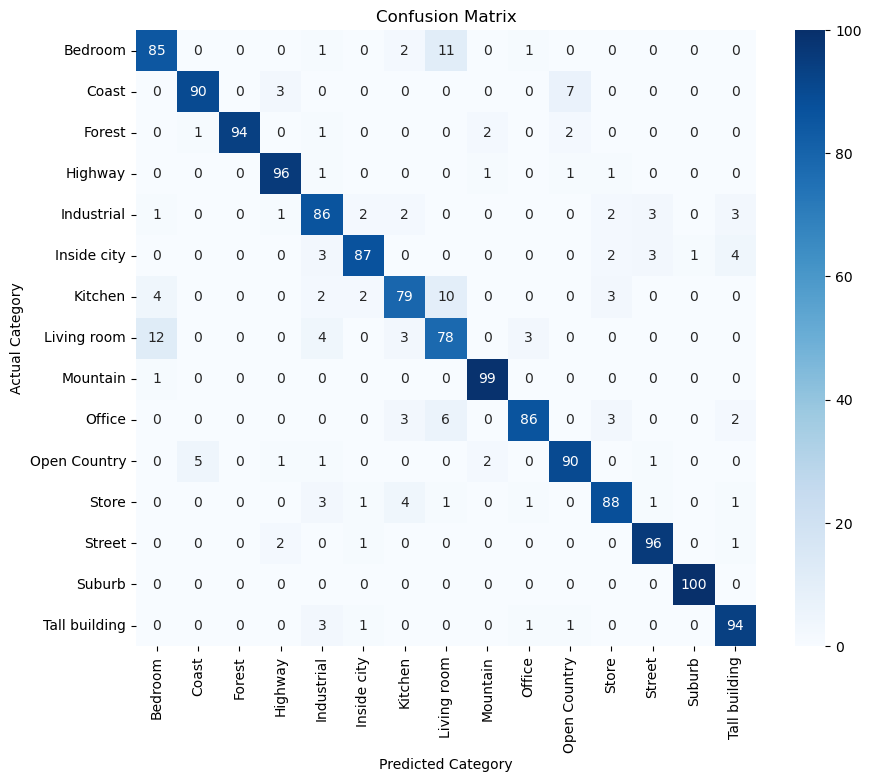

In [9]:

num_classes = 15  # This should match the number of categories
checkpoint_path = './models/cnn_squeeze_final_epoch_50.pt'
model = load_model(checkpoint_path, num_classes)

# Setup the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Assuming valid_loader is already set up correctly
actual_labels = []
predicted_labels = []

# Evaluate the model to get predictions
model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        actual_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Compute the confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Define category names for better visualization
category_names = [
    'Bedroom', 'Coast', 'Forest', 'Highway', 'Industrial',
    'Inside city', 'Kitchen', 'Living room', 'Mountain', 'Office',
    'Open Country', 'Store', 'Street', 'Suburb', 'Tall building'
]

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=category_names, yticklabels=category_names)
plt.title('Confusion Matrix')
plt.ylabel('Actual Category')
plt.xlabel('Predicted Category')
plt.show()